In [1]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier
#from sklearn.lda import LDA
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import sklearn.linear_model as linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.discrete.discrete_model import MNLogit

/Users/A123/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Content:
* 1. Data Cleaning and Processing (From Urwa)
* 2. Build classification model and interpretation
* 3. Build the logit regression model and interpretation

# 1. Data Cleaning and Processing

## 1.1 tax data

Tax Data: CDC STATE System Tobacco Legislation - Tax： https://chronicdata.cdc.gov/Legislation/CDC-STATE-System-Tobacco-Legislation-Tax/2dwv-vfam

In [2]:
!curl https://chronicdata.cdc.gov/api/views/2dwv-vfam/rows.csv?accessType=DOWNLOAD > Tax.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.5M    0 33.5M    0     0  3541k      0 --:--:--  0:00:09 --:--:-- 3640k


In [3]:
#Pick the Cigeratte tax rate in 2017
tax = pd.read_csv('Tax.csv')
tax17 = tax[tax['Year']==2017]
tax17.head()

/Users/A123/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,...,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID
120339,2017,1,MN,Minnesota,Legislation - Tax Combustible Tobacco,Little Cigar,OSH,Restrictions,Little Cigar Tax ($ per pack of 20),3.0400,...,NaN,10/31/2016,1/1/2017,"(46.35564873600049, -94.79420050299967)",2,LEG,1010LEG,672LCG,10GRP,417
121546,2017,2,CA,California,Legislation - Tax Combustible Tobacco,Little Cigar,OSH,Restrictions,Little Cigar Tax ($ per pack of 20),2.8700,...,Currently products labeled as little or small ...,10/31/2016,4/1/2017,"(37.63864012300047, -120.99999953799971)",2,LEG,1010LEG,672LCG,10GRP,417
121547,2017,2,CA,California,Legislation - Tax Combustible Tobacco,Cigarette,OSH,Restrictions,Cigarette Tax ($ per pack),2.870,...,NaN,10/31/2016,4/1/2017,"(37.63864012300047, -120.99999953799971)",5,LEG,1010LEG,670CGR,10GRP,411
121548,2017,1,MI,Michigan,Legislation - Tax Stamp,Tax Stamp,OSH,Requirements,Barcode/Scannable Code Required,Yes,...,NaN,6/20/2012,6/20/2012,"(44.6613195430005, -84.71439026999968)",2,LEG,1030LEG,690CET,12GRP,350
121549,2017,1,RI,Rhode Island,Legislation - Tax Non-Combustible Tobacco,Dry Snuff Tobacco,OSH,Restrictions,Dry Snuff Tobacco Tax,Yes,...,NaN,1/1/1995,1/1/1995,"(41.70828019300046, -71.52247031399963)",1,LEG,1020LEG,682EDS,10GRP,392


In [4]:
tax_value = tax17[tax17['ProvisionDesc'] == 'Cigarette Tax ($ per pack)'].sort_values('LocationDesc')
tax_value = tax_value.groupby('LocationDesc').max()
tax_value = tax_value[['ProvisionAltValue']]
tax_value.rename(columns={'ProvisionAltValue':'Cigarette_tax'}, inplace=True)
tax_value.reset_index(inplace=True)
tax_value.head()

,LocationDesc,Cigarette_tax
0,Alabama,0.675
1,Alaska,2.000
2,American Samoa,6.000
3,Arizona,2.000
4,Arkansas,1.150


## 1.2 BRFSS data

In [5]:
cleandata = pd.read_csv('data/cleanDataSmoke.csv')
cleandata.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_drinkbinge,ads18_fruitIntake,ads18_vegIntake,ads18_potatoIntake,ads18_exercise,ads18_hivtest,ads18_affordDoc,ads18_stroke,ads18_state,label
0,False,True,False,False,False,False,True,8890.0,True,False,...,False,2.0,29.0,43.0,True,True,True,False,Alabama,Yes
1,False,False,False,True,False,False,True,7484.0,True,False,...,False,100.0,100.0,43.0,True,False,True,False,Alabama,Yes
2,False,False,True,False,False,False,True,5897.0,False,False,...,False,29.0,33.0,7.0,True,True,True,False,Alabama,Yes
3,False,False,False,False,False,False,True,11340.0,True,True,...,False,57.0,43.0,43.0,True,True,True,False,Alabama,Yes
4,False,False,False,True,False,False,True,4536.0,False,True,...,True,67.0,17.0,67.0,False,True,False,False,Alabama,Yes


In [6]:
cleandata_tax = pd.merge(cleandata, tax_value, left_on = 'ads18_state', right_on = 'LocationDesc')
cleandata_tax.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_vegIntake,ads18_potatoIntake,ads18_exercise,ads18_hivtest,ads18_affordDoc,ads18_stroke,ads18_state,label,LocationDesc,Cigarette_tax
0,False,True,False,False,False,False,True,8890.0,True,False,...,29.0,43.0,True,True,True,False,Alabama,Yes,Alabama,0.675
1,False,False,False,True,False,False,True,7484.0,True,False,...,100.0,43.0,True,False,True,False,Alabama,Yes,Alabama,0.675
2,False,False,True,False,False,False,True,5897.0,False,False,...,33.0,7.0,True,True,True,False,Alabama,Yes,Alabama,0.675
3,False,False,False,False,False,False,True,11340.0,True,True,...,43.0,43.0,True,True,True,False,Alabama,Yes,Alabama,0.675
4,False,False,False,True,False,False,True,4536.0,False,True,...,17.0,67.0,False,True,False,False,Alabama,Yes,Alabama,0.675


In [7]:
df_categ_ = cleandata_tax.copy()
labelencoder = LabelEncoder()
for c in df_categ_.columns:
    if df_categ_[c].dtype.name == 'object':
        df_categ_[c] = labelencoder.fit_transform(df_categ_[c])
df_categ_.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_vegIntake,ads18_potatoIntake,ads18_exercise,ads18_hivtest,ads18_affordDoc,ads18_stroke,ads18_state,label,LocationDesc,Cigarette_tax
0,False,True,False,False,False,False,True,8890.0,True,False,...,29.0,43.0,True,True,True,False,0,1,0,0.675
1,False,False,False,True,False,False,True,7484.0,True,False,...,100.0,43.0,True,False,True,False,0,1,0,0.675
2,False,False,True,False,False,False,True,5897.0,False,False,...,33.0,7.0,True,True,True,False,0,1,0,0.675
3,False,False,False,False,False,False,True,11340.0,True,True,...,43.0,43.0,True,True,True,False,0,1,0,0.675
4,False,False,False,True,False,False,True,4536.0,False,True,...,17.0,67.0,False,True,False,False,0,1,0,0.675


In [8]:
for c in df_categ_.columns:
    print(df_categ_[c].dtype.name == 'bool')

True
True
True
True
True
True
True
False
True
True
False
False
True
True
False
False
False
True
True
True
True
False
False
False
False


In [9]:
labelencoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
def OHEncoder(DF):
    df = DF.copy()
    for c in df.columns:
        if df[c].dtype.name == 'bool':
            #df[c] = labelencoder.fit_transform(df[c])
            integer_encoded = np.asarray(df[c]).reshape(len(df[c]), 1)
            df[c] = onehot_encoder.fit_transform(integer_encoded)
    return df
df_categ = OHEncoder(df_categ_)
df_categ = df_categ.dropna()
df_categ.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_vegIntake,ads18_potatoIntake,ads18_exercise,ads18_hivtest,ads18_affordDoc,ads18_stroke,ads18_state,label,LocationDesc,Cigarette_tax
0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,8890.0,0.0,1.0,...,29.0,43.0,0.0,0.0,0.0,1.0,0,1,0,0.675
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,7484.0,0.0,1.0,...,100.0,43.0,0.0,1.0,0.0,1.0,0,1,0,0.675
2,1.0,1.0,0.0,1.0,1.0,1.0,0.0,5897.0,1.0,1.0,...,33.0,7.0,0.0,0.0,0.0,1.0,0,1,0,0.675
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11340.0,0.0,0.0,...,43.0,43.0,0.0,0.0,0.0,1.0,0,1,0,0.675
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,4536.0,1.0,0.0,...,17.0,67.0,1.0,0.0,1.0,1.0,0,1,0,0.675


In [10]:
print(df_categ['label'].value_counts())

1    50092
0     5861
Name: label, dtype: int64


### Note: This data set has serious class imbalance issue

In [11]:
#Address class imbalance:
def classImballanceDownSample(df,ycol):
    df = df.copy()
    valueCount = df[ycol].value_counts()
    print("Before Class Imballance Treatment: ")
    print(valueCount)
    classes = valueCount.index
    counts = valueCount.values
    minClassSize = np.min(counts)
    for clas in classes:
        df1 = df[df[ycol]==clas]
        df2 = df[df[ycol]!=clas]
        
        df1 = df1.sample(n=minClassSize, random_state=50)
        df = df1.append(df2)
    #shuffling the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    print("After Class Imballance Treatment: ")
    print(df[ycol].value_counts())
    return df 

In [12]:
df_categ = classImballanceDownSample(df_categ, 'label')

Before Class Imballance Treatment: 
1    50092
0     5861
Name: label, dtype: int64
After Class Imballance Treatment: 
1    5861
0    5861
Name: label, dtype: int64


In [13]:
df_categ.shape

(11722, 25)

In [14]:
label = df_categ[['label']]
X = df_categ.drop(['label'], axis=1)

In [15]:
label.shape

(11722, 1)

In [16]:
X.shape

(11722, 24)

In [17]:
#0:Both; 1: E-smoker; 2: None 3: Smoker
for c in label.columns:
    print(c)
    print(label[c].value_counts())
    print()

label
1    5861
0    5861
Name: label, dtype: int64



# 2. Feature selection

### 2.1 Random Forest (RF) Classifier

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, label, test_size=0.33, random_state=100)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(7853, 24) (7853, 1) (3869, 24) (3869, 1)


In [19]:
#fit Random Forest and test the accuracy:
def RandomForest(x_train, y_train, x_test, y_test):   
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(x_train, y_train)   
    y_pred = rf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    MSE_rf = mean_squared_error(y_test, y_pred)
    ACC_rf = (cm[0][0] + cm[1][1]) / (len(y_pred))
    #accuracy = metrics.accuracy_score(test_y, predictions)
    table_rf = [[' ','0', '1'],
             ['0', cm[0][0], cm[0][1]],
             ['1', cm[1][0], cm[1][1]]] 
            
    #feature_importances = rf.feature_importances_
    #top5_rf = sorted(feature_importances, reverse=True)[:5]
    importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(rf.feature_importances_,5)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    
    print("The confusion matrix is:")
    print(tabulate(table_rf, tablefmt="fancy_grid", numalign = "center"))
    print('The Accuracy Rate is', ACC_rf)
    print('The Mean Squared Error is:', MSE_rf)
    print('-------------------------------------------------')
    print('The Classification Report is:')
    print(classification_report(y_test, y_pred))
    print('The Feature Importance is:')
    print(importances)
    
    return ACC_rf, MSE_rf, importances
    #print(feature_importances)
    #print('The Top 5 important features are:')
    #print([(x_train.columns[feature_importances.tolist().index(top5_rf[i])], top5_rf[i]) for i in range(5)])

In [20]:
ACC_rf, MSE_rf, importances = RandomForest(X_train, Y_train, X_test, Y_test)

/Users/A123/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


The confusion matrix is:
╒═══╤══════╤══════╕
│   │  0   │  1   │
├───┼──────┼──────┤
│ 0 │ 1215 │ 718  │
├───┼──────┼──────┤
│ 1 │ 773  │ 1163 │
╘═══╧══════╧══════╛
The Accuracy Rate is 0.6146291031274231
The Mean Squared Error is: 0.3853708968725769
-------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

          0       0.61      0.63      0.62      1933
          1       0.62      0.60      0.61      1936

avg / total       0.61      0.61      0.61      3869

The Feature Importance is:
                           importance
feature                              
ads18_weight                  0.11837
ads18_vegIntake               0.08862
ads18_potatoIntake            0.08852
ads18_state                   0.08653
LocationDesc                  0.08635
ads18_fruitIntake             0.08569
Cigarette_tax                 0.08561
ads18_income                  0.05407
ads18_edu                     0.04717
ads18_hiv

## 2.2 K-nearest-neighbour Classifier

In [21]:
def KNN(x, y, x_train, y_train, x_test, y_test):
    NN = int(np.sqrt(len(x_train)))
    how = 'distance'
    n_feats = len(x.columns)
    knn = neighbors.KNeighborsClassifier(NN, how)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    MSE_knn = mean_squared_error(y_test, y_pred)
    ACC_knn = (cm[0][0] + cm[1][1]) / (len(y_pred))
    #accuracy = metrics.accuracy_score(test_y, predictions)
    table_knn = [[' ','0', '1'],
             ['0', cm[0][0], cm[0][1]],
             ['1', cm[1][0], cm[1][1]]] 
    
    print("The confusion matrix is:")
    print(tabulate(table_knn, tablefmt="fancy_grid", numalign = "center"))
    print('The Accuracy Rate is', ACC_knn)
    print('The Mean Squared Error is:', MSE_knn)
    print('-------------------------------------------------')
    print('The Classification Report is:')
    print(classification_report(y_test, y_pred))
    return ACC_knn, MSE_knn
    #print('Feature  Accuracy')
    #for i in range(n_feats):
        #X = x[:, i].reshape(-1, 1)
        #scores = cross_val_score(knn, x, y)
        #print('%d        %g' % (x.columns[i], scores.mean()))

In [22]:
ACC_knn, MSE_knn = KNN(X, label, X_train, Y_train, X_test, Y_test)

/Users/A123/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


The confusion matrix is:
╒═══╤══════╤═════╕
│   │  0   │  1  │
├───┼──────┼─────┤
│ 0 │ 1146 │ 787 │
├───┼──────┼─────┤
│ 1 │ 1041 │ 895 │
╘═══╧══════╧═════╛
The Accuracy Rate is 0.5275264926337555
The Mean Squared Error is: 0.4724735073662445
-------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

          0       0.52      0.59      0.56      1933
          1       0.53      0.46      0.49      1936

avg / total       0.53      0.53      0.53      3869



## 2.3 Naive Bayes (NB) Classifier

In [23]:
def GNB(x_train, y_train, x_test, y_test):
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    MSE_gnb = mean_squared_error(y_test, y_pred)
    ACC_gnb = (cm[0][0] + cm[1][1]) / (len(y_pred))
    #accuracy = metrics.accuracy_score(test_y, predictions)
    table_gnb = [[' ','0', '1'],
             ['0', cm[0][0], cm[0][1]],
             ['1', cm[1][0], cm[1][1]]] 
    
    print("The confusion matrix is:")
    print(tabulate(table_gnb, tablefmt="fancy_grid", numalign = "center"))
    print('The Accuracy Rate is', ACC_gnb)
    print('The Mean Squared Error is:', MSE_gnb)
    print('-------------------------------------------------')
    print('The Classification Report is:')
    print(classification_report(y_test, y_pred))
    return ACC_gnb, MSE_gnb

In [24]:
ACC_gnb, MSE_gnb = GNB(X_train, Y_train, X_test, Y_test)

The confusion matrix is:
╒═══╤══════╤══════╕
│   │  0   │  1   │
├───┼──────┼──────┤
│ 0 │ 1158 │ 775  │
├───┼──────┼──────┤
│ 1 │ 741  │ 1195 │
╘═══╧══════╧══════╛
The Accuracy Rate is 0.6081674851382787
The Mean Squared Error is: 0.3918325148617214
-------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

          0       0.61      0.60      0.60      1933
          1       0.61      0.62      0.61      1936

avg / total       0.61      0.61      0.61      3869



/Users/A123/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 2.4 Random guessing

In [25]:
def Guess(y):
    y_pred = np.random.permutation(y)
    cm = confusion_matrix(y, y_pred)
    MSE_guess = mean_squared_error(y, y_pred)
    ACC_guess = (cm[0][0] + cm[1][1]) / (len(y_pred))
    #accuracy = metrics.accuracy_score(test_y, predictions)
    table_guess = [[' ','0', '1'],
             ['0', cm[0][0], cm[0][1]],
             ['1', cm[1][0], cm[1][1]]]
    
    print("The confusion matrix is:")
    print(tabulate(table_guess, tablefmt="fancy_grid", numalign = "center"))
    print('The Accuracy Rate is', ACC_guess)
    print('The Mean Squared Error is:', MSE_guess)
    print('-------------------------------------------------')
    print('The Classification Report is:')
    print(classification_report(y, y_pred))
    return ACC_guess, MSE_guess

In [26]:
ACC_guess, MSE_guess = Guess(label)

The confusion matrix is:
╒═══╤══════╤══════╕
│   │  0   │  1   │
├───┼──────┼──────┤
│ 0 │ 2912 │ 2949 │
├───┼──────┼──────┤
│ 1 │ 2949 │ 2912 │
╘═══╧══════╧══════╛
The Accuracy Rate is 0.49684354205766934
The Mean Squared Error is: 0.5031564579423307
-------------------------------------------------
The Classification Report is:
             precision    recall  f1-score   support

          0       0.50      0.50      0.50      5861
          1       0.50      0.50      0.50      5861

avg / total       0.50      0.50      0.50     11722



## 2.5 Compare the above results:

In [27]:
method = ['RF', 'KNN', 'GaussianNB', 'Random guess']
ACC = [ACC_rf, ACC_knn, ACC_gnb, ACC_guess]
MSE = [MSE_rf, MSE_knn, MSE_gnb, MSE_guess]
for i in range(4):
    print(method[i])
    print('The Accuracy Rate is: %s'%ACC[i])
    print('The Mean Squared Error is: %s'%MSE[i])
    print()
print('-----------------------------------------')
print('Top 5 importance features based on RF:')
print(importances[:5])

RF
The Accuracy Rate is: 0.6146291031274231
The Mean Squared Error is: 0.3853708968725769

KNN
The Accuracy Rate is: 0.5275264926337555
The Mean Squared Error is: 0.4724735073662445

GaussianNB
The Accuracy Rate is: 0.6081674851382787
The Mean Squared Error is: 0.3918325148617214

Random guess
The Accuracy Rate is: 0.49684354205766934
The Mean Squared Error is: 0.5031564579423307

-----------------------------------------
Top 5 importance features based on RF:
                    importance
feature                       
ads18_weight           0.11837
ads18_vegIntake        0.08862
ads18_potatoIntake     0.08852
ads18_state            0.08653
LocationDesc           0.08635


# 3. Build the logit model to do the interpretation

In [28]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(7853, 24) (7853, 1) (3869, 24) (3869, 1)


In [29]:
Y_train.head()

,label
9496,1
2123,0
818,1
1849,1
6293,1


In [30]:
mnlogit = MNLogit(Y_train, X_train).fit()
print(mnlogit.summary())

Optimization terminated successfully.
         Current function value: 0.659633
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                  label   No. Observations:                 7853
Model:                        MNLogit   Df Residuals:                     7830
Method:                           MLE   Df Model:                           22
Date:                Mon, 17 Dec 2018   Pseudo R-squ.:                 0.04835
Time:                        19:02:55   Log-Likelihood:                -5180.1
converged:                       True   LL-Null:                       -5443.3
                                        LLR p-value:                 2.289e-97
                  label=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue    -0.0099      0.067     -0.148      0.882      -0.

/Users/A123/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3967: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))
/Users/A123/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/A123/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/A123/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/A123/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [31]:
marginal = mnlogit.get_margeff()
print(marginal.summary())

       MNLogit Marginal Effects      
Dep. Variable:                  label
Method:                          dydx
At:                           overall
                  label=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue     0.0023   3393.513   6.81e-07      1.000   -6651.160    6651.165
ads18_highBP                  0.1000   4325.450   2.31e-05      1.000   -8477.627    8477.827
ads18_highChl                 0.0061   1933.990   3.14e-06      1.000   -3790.544    3790.556
ads18_unknownChl             -0.1241   2.63e+04  -4.72e-06      1.000   -5.15e+04    5.15e+04
ads18_asthma                 -0.0234   6366.963  -3.68e-06      1.000   -1.25e+04    1.25e+04
ads18_formerasthma           -0.1543        nan        nan        nan         nan         nan
ads18_white                  -0.0447        nan        nan        nan         nan         nan
ad

/Users/A123/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))
/Users/A123/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/A123/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/A123/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [37]:
pred = mnlogit.predict(X_test)
scores = np.arange(0, 1, .05)

In [38]:
def ROC(actual, pred, scores):
    
    tpr = np.zeros((len(scores),), dtype=np.float)
    fpr = np.zeros((len(scores),), dtype=np.float)
    acc = np.zeros((len(scores),), dtype=np.float)
    mse = np.zeros((len(scores),), dtype=np.float)
    
    for i in range(len(scores)):
        prediction = np.zeros((len(pred),), dtype=np.int)
        for j in range(len(pred)):
            if np.array(pred)[j][1] > scores[i]: prediction[j] += 1      
        cm = confusion_matrix(actual, prediction)
        ms = mean_squared_error(actual, prediction)
        TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        tpr[i] = TP/(TP + FN)
        fpr[i] = FP/(TN + FP)
        acc[i] = (TN + TP) / (TN + FP + FN + TP)
        mse[i] = ms
        
    threshold = np.where(mse==mse.min())
    print('The best threshold is', scores[threshold])
    print('The highest accuracy rate is', acc[threshold])
    print('The minimum MSE is', mse[threshold])    
    
    return tpr, fpr, acc, mse

In [39]:
TPR, FPR, ACC, MSE = ROC(Y_test, pred, scores)

The best threshold is [0.5]
The highest accuracy rate is [0.61049367]
The minimum MSE is [0.38950633]


Text(0.5,1,'Receiver Operating Characteristic (ROC) Curve')

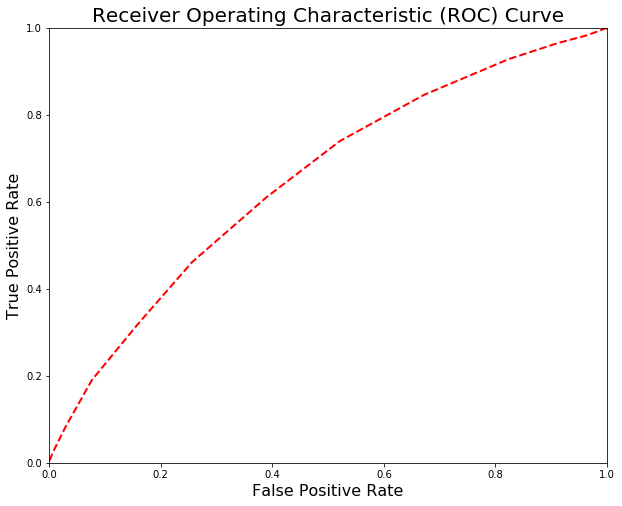

In [40]:
plt.figure(figsize=(10,8))
plt.plot(FPR, TPR, 'r--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)

Text(0.5,1,'Accuracy Rates')

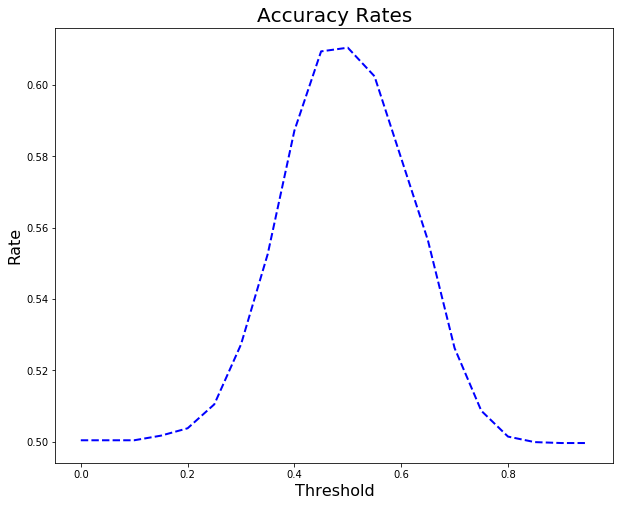

In [41]:
plt.figure(figsize=(10, 8))
plt.plot(scores, ACC, 'b--', lw=2)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Rate', fontsize=16)
plt.title('Accuracy Rates', fontsize=20)

Text(0.5,1,'MSE')

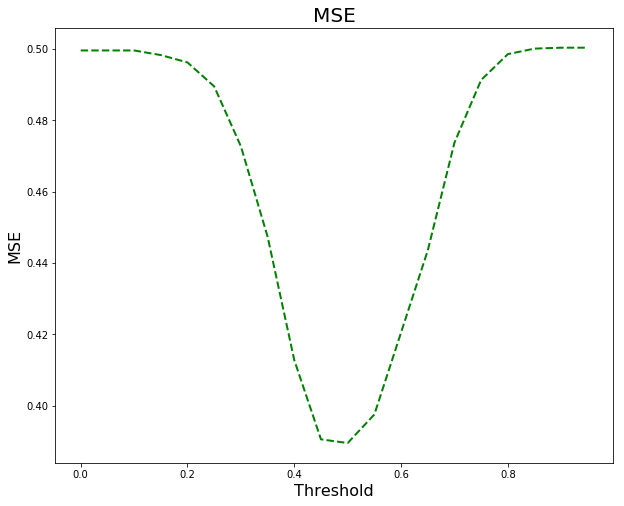

In [43]:
plt.figure(figsize = (10, 8))
plt.plot(scores, MSE, 'g--', lw=2)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.title('MSE', fontsize=20)